In [1]:
%matplotlib inline
from matplotlib.pyplot import *
from numpy import *
import json
import datetime
import unicodedata
from pylab import rcParams
import os

In [2]:
rcParams['figure.figsize'] = 16,10
rcParams['font.size'] = 20

In [3]:
mes={}
names=[]
for s in next(os.walk('.\\messages\\inbox\\'))[1]:
    dir=os.getcwd()+"\\messages\\inbox\\"+s
    name=s.split('_')[0]
    messages = []
    i = 1
    while True:
        try:
            f = open(dir + "\\message_" + str(i) + ".json", 'r', encoding='utf8')
        except:
            break
        i += 1
        s = f.read().encode().decode('raw_unicode_escape').encode('latin1').decode('utf8')
        f = open('out.txt', 'w', encoding='utf8')
        f.write(s)
        js = json.loads(s, strict=False)
        for m in js["messages"]:
            messages.append(m)
    messages.reverse()
    repeat=0
    while name in mes:
        repeat+=1
        name=name+str(repeat)
    names.append(name)
    mes[name]=messages

In [4]:
messageCounts=[]
for mm, messages in mes.items():
    messageCounts.append(len(messages))
sortedNames, sortedNumbers=list(zip(*[(x, y) for y,x in sorted(zip(messageCounts,names), reverse=True)]))

In [5]:
def printFirsts (n):
    ii=0    
    for x,y in zip(sortedNames[:n],sortedNumbers[:n]):
        ii+=1
        print("%d. %s: %d üzenet" % (ii,x,y))

In [6]:
def getTime(messages):
    timestamps = []
    for m in messages:
        #timestamps.append(m['timestamp_ms'])
        timestamps.append(datetime.datetime.fromtimestamp(m['timestamp_ms']//1000))
    return timestamps

In [7]:
def messages_time (name):
    if type(name)==str:
        messages=mes[name]
        timestamps=getTime(messages)
        plot(timestamps, [i/1000 for i in range(len(timestamps))], "r")
        
    else:
        for na in name:
            messages=mes[na]
            timestamps=getTime(messages)
            plot(timestamps, [i/1000 for i in range(len(timestamps))], label=na)
            legend()
    
    xticks(fontsize=15, rotation = 90)
    xlabel("Dátum")
    ylabel("Üzenetek száma (ezer)")
    title("Üzenetek száma az idők során")
    grid(True)

In [8]:
def senderStats (messages):
    statsPerSender = {}

    for m in messages:
        if 'content' in m.keys():
            emojis = 0 #emoji.emoji_count(m['content'])
            words = len(m['content'].split())
            letters = len(m['content']) - emojis - words + 1
            if m['sender_name'] in statsPerSender:
                statsPerSender[m['sender_name']]['letter_count'] += letters
                statsPerSender[m['sender_name']]['emoji_count'] += emojis
                statsPerSender[m['sender_name']]['word_count'] += words
                statsPerSender[m['sender_name']]['message_count'] += 1
            else:
                statsPerSender[m['sender_name']] = {'letter_count': letters, 'emoji_count': emojis, 'word_count': words, 'message_count': 1}

    for s in statsPerSender:
        statsPerSender[s]['avg_word_len'] =    round(statsPerSender[s]['letter_count'] / statsPerSender[s]['word_count'], 1)
        statsPerSender[s]['avg_message_len'] = round(statsPerSender[s]['letter_count'] / statsPerSender[s]['message_count'], 1)

    print("Leírt karakterek")
    for s in sorted(statsPerSender.keys(), key=lambda x: statsPerSender[x]['letter_count'], reverse=True):
        print(s, ": ", statsPerSender[s]['letter_count'])

    #print("\nEmojik száma")
    #for s in sorted(statsPerSender.keys(), key=lambda x: statsPerSender[x]['emoji_count'], reverse=True):
    #    print(s, ": ", statsPerSender[s]['emoji_count'])

    print("\nSzavak száma")
    for s in sorted(statsPerSender.keys(), key=lambda x: statsPerSender[x]['word_count'], reverse=True):
        print(s, ": ", statsPerSender[s]['word_count'])

    print("\nÁtlagos szóhossz")
    for s in sorted(statsPerSender.keys(), key=lambda x: statsPerSender[x]['avg_word_len'], reverse=True):
        print(s, ": ", statsPerSender[s]['avg_word_len'])

    print("\nÁtlagos üzenethossz karakterben")
    for s in sorted(statsPerSender.keys(), key=lambda x: statsPerSender[x]['avg_message_len'], reverse=True):
        print(s, ": ", statsPerSender[s]['avg_message_len'])
    print("\n")

In [9]:
def messages_timeofday(messages):
    timestamps=getTime(messages)
    quarters = zeros(24 * 4)

    for t in timestamps:
        index = t.hour * 4 + t.minute // 15
        quarters[index] += 1

    kernel = array([0.09672046549155401, 0.24044903390287659, 0.3256610012111388, 0.24044903390287659, 0.09672046549155401])
    r = kernel.size // 2
    smoothed = zeros(24 * 4)
    for i in range(24 * 4):
        s = 0
        for j in range(-r, r + 1):
            s += kernel[j + r] * quarters[(i + j) % (24 * 4)]
        smoothed[i] = s / 15
            
    x = [i / 4 for i in range(24 * 4)]
    plot(x, smoothed,"r")

    xlabel("Napon belüli órák")
    ylabel("Üzenetek száma ebben a percebn")
    title("Az üzenetek relatív gyakorisága a napon belül")
    xticks([0,4,8,12,16,20,24])

    xlim(0, 24.00)
    grid(True)
    show()

In [10]:
def getFlatMess(messages):
    flatMess = []
    for m in messages.copy():
        if "content" in m.keys():
            m2 = m.copy()
            s = m['content']
            m2['content'] = unicodedata.normalize('NFD', s).encode('ascii', 'ignore').lower().decode("utf-8") 
            flatMess.append(m2)
    return flatMess

In [11]:
def searchCount(messages, key):
    key = unicodedata.normalize('NFD', key).encode('ascii', 'ignore').lower().decode("utf-8") 
    result = dict()
    for m in messages:
        c = m['content'].count(key)
        if (m['sender_name'] in result):
            result[m['sender_name']]['count'] += c
        else:
            result[m['sender_name']] = {'count': c}

    return result

In [12]:
def WordNumber (messages, key):
    flatMess=getFlatMess(messages)
    hits = searchCount(flatMess, key)

    print("Találatok száma a(z) \"" + str(key) + "\" kifejezésre")
    for s in sorted(hits.keys(), key=lambda x: hits[x]['count'], reverse=True):
        print(s, ": ", hits[s]['count'])
    print("\n")

In [13]:
def getWordCounts(messsages):
    wordCounts = dict()
    flatMess=getFlatMess(messages)
    for m in flatMess:
            words = m['content'].split()
            for word in words:
                if (m['sender_name'] in wordCounts):
                    if (word in wordCounts[m['sender_name']]):
                        wordCounts[m['sender_name']][word] += 1
                    else:
                        wordCounts[m['sender_name']][word] = 1
                else:
                    wordCounts[m['sender_name']] = {word: 1}
    return wordCounts

In [14]:
def mostUsedWords(messages):
    wordCounts=getWordCounts(messages)
    print("Legtöbbször használt szavak:")
    for s in wordCounts.keys():
        print(s)
        for w in sorted(wordCounts[s], key=wordCounts[s].get, reverse=True)[0:11]:
            print(w, ":", wordCounts[s][w])
        print()
        #print(sorted(wordCounts[s], key=wordCounts[s].get, reverse=True))

    #sorted(wordCounts[s], key=wordCounts[s].get, reverse=True)
    #wordCounts[s]

In [15]:
def time_elapsed(resp, messages):
    last_sender=messages[0]["sender_name"]
    last_time=messages[0]["timestamp_ms"]
    response_times=[]

    for m in messages:
        if (last_sender!=resp and m["sender_name"]==resp):
            response_times.append((m["timestamp_ms"]-last_time)/1000/60)
        last_sender=m["sender_name"]
        last_time=m["timestamp_ms"]
    
    return response_times

In [16]:
def histplot(respo, re):
    counts,bins=histogram(respo, bins=30, range=(0,5))
    portion=sum(counts)*100/len(respo)
    print("%s válaszainak %.1f%%-a 5 percen belül érkezik" % (re,portion))

    counts2,bins2=histogram(respo, bins=30, range=(0,1))
    portion2=sum(counts2)*100/len(respo)
    print("%s válaszainak %.1f%%-a 1 percen belül érkezik\n" % (re,portion2))
    
    respo2=[x if x<=5 else 5.2 for x in respo]
    hist(respo2, 100, range=(0,5.2), density=True, histtype='step',cumulative=True, label="%s válaszai" % re)


In [17]:
def getParticipants (messages):
    participants=[]
    for m in messages:
        if m["sender_name"] in participants:
            continue
        participants.append(m["sender_name"])
    return participants

In [18]:
def responseTime(messages):
    for responder in getParticipants(messages):
        response_times=time_elapsed(responder, messages)
        histplot(response_times, responder)


    title("Az egymás üzeneteire adott válaszidők kumulatív eloszlásfüggvénye")
    xlabel("Válaszidő (perc)")
    ylabel("Megválaszolt üzenetek részaránya")
    xlim(0,5)
    legend(loc="lower right")
    grid(True)
    show()


In [29]:
def allInfo(name, szo="fasz"):
    mm=mes[name]
    senderStats(mm)
    WordNumber(mm,szo)
    responseTime(mm)
    messages_timeofday(mm)
    messages_time(name)
    

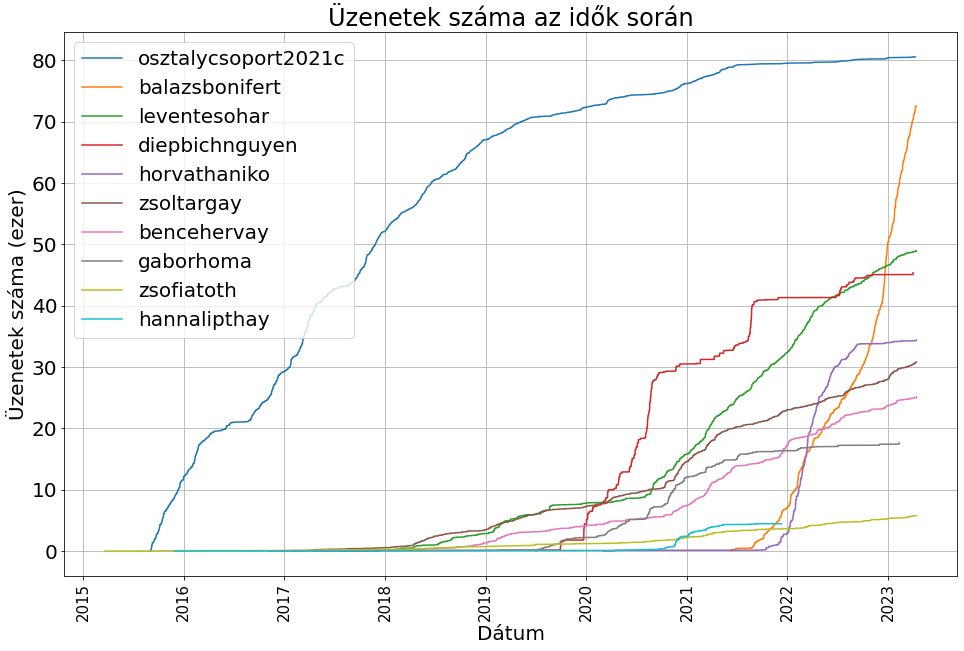

In [20]:
messages_time(sortedNames[0:10])


In [21]:
printFirsts(15)

1. osztalycsoport2021c: 80577 üzenet
2. balazsbonifert: 72585 üzenet
3. leventesohar: 48977 üzenet
4. diepbichnguyen: 45390 üzenet
5. horvathaniko: 34413 üzenet
6. zsoltargay: 30809 üzenet
7. bencehervay: 25159 üzenet
8. gaborhoma: 17617 üzenet
9. zsofiatoth: 5795 üzenet
10. hannalipthay: 4465 üzenet
11. vazsonyvarga: 4258 üzenet
12. afizikaszakkremje: 4178 üzenet
13. eszteresgabor: 3675 üzenet
14. zsomborvarkonyi: 3626 üzenet
15. eltettkfizika2021: 3482 üzenet


In [22]:
sortedNames.index("balazsbonifert")

1

Leírt karakterek
Ábel Tóth :  1030297
Balázs Bonifert :  956668

Szavak száma
Ábel Tóth :  206649
Balázs Bonifert :  194696

Átlagos szóhossz
Ábel Tóth :  5.0
Balázs Bonifert :  4.9

Átlagos üzenethossz karakterben
Balázs Bonifert :  29.3
Ábel Tóth :  26.8


Találatok száma a(z) "kur" kifejezésre
Ábel Tóth :  104
Balázs Bonifert :  88


Ábel Tóth válaszainak 91.9%-a 5 percen belül érkezik
Ábel Tóth válaszainak 80.7%-a 1 percen belül érkezik

Balázs Bonifert válaszainak 94.2%-a 5 percen belül érkezik
Balázs Bonifert válaszainak 85.2%-a 1 percen belül érkezik



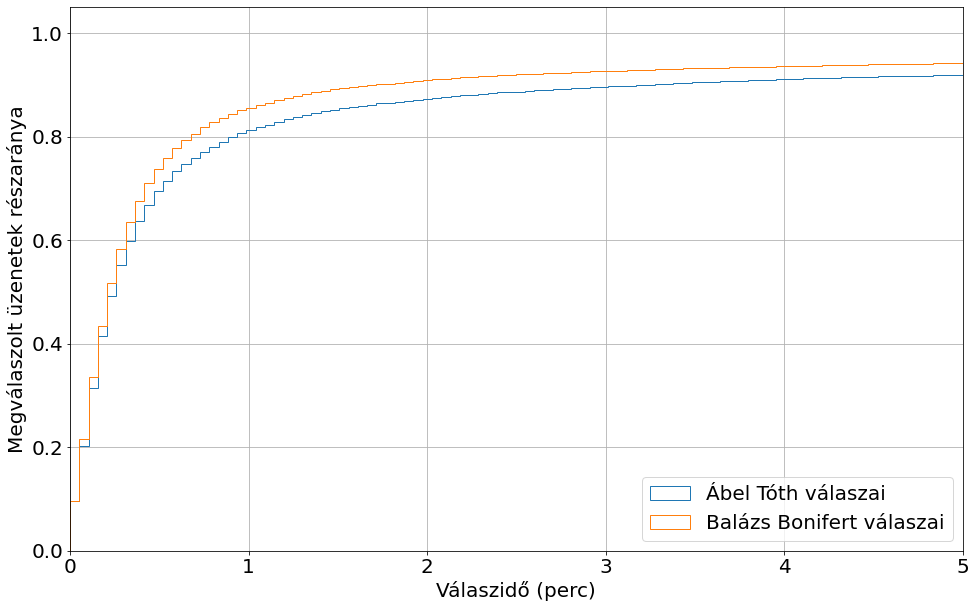

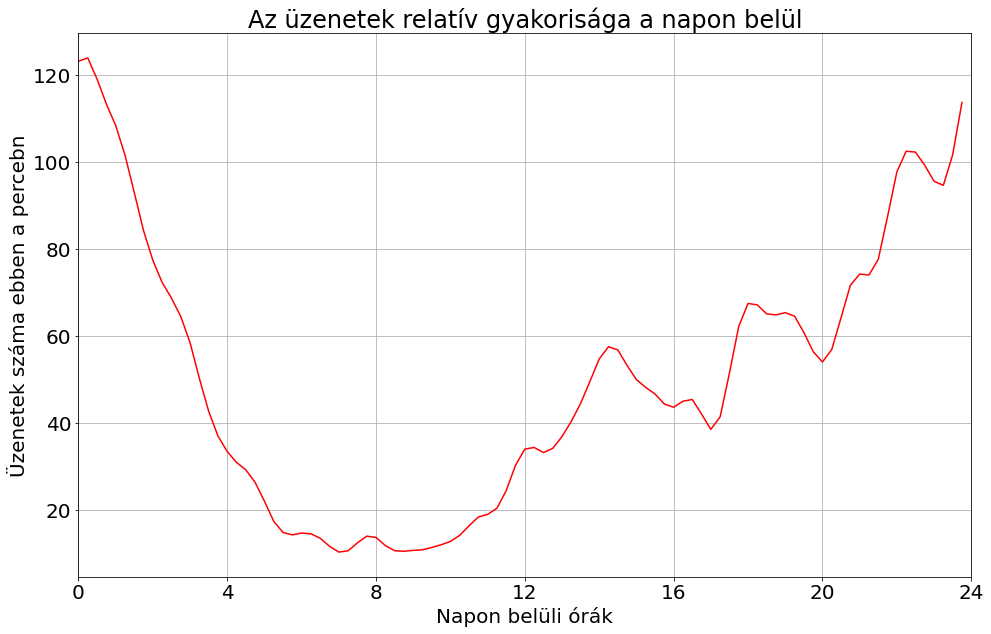

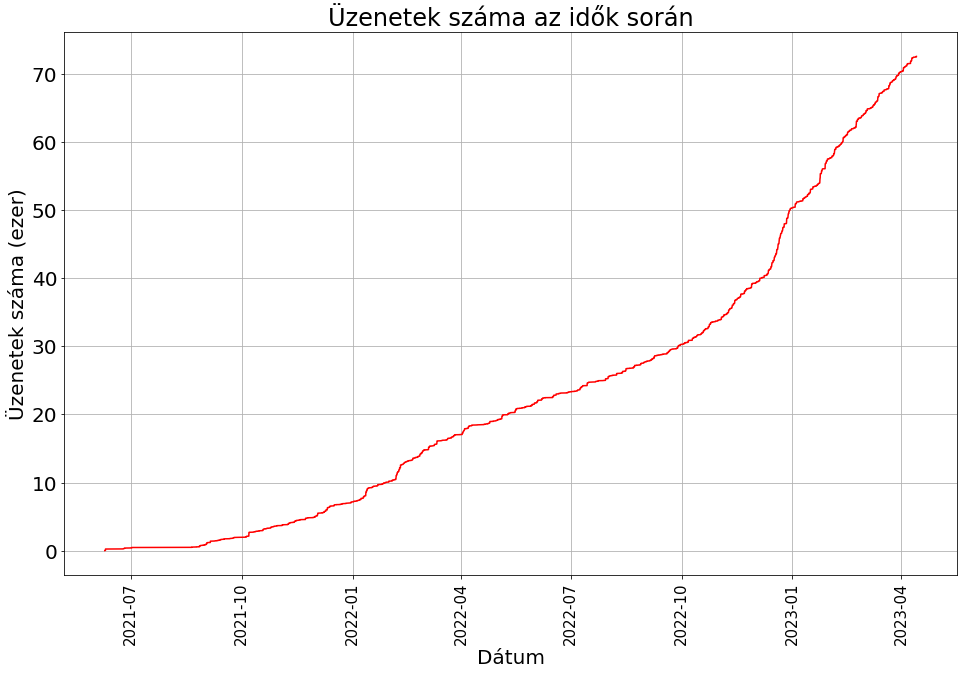

In [33]:
allInfo("balazsbonifert", szo="kur")

In [24]:
mm=mes["balazsbonifert"]
WordNumber(mm,"xd")
WordNumber(mm,"xdd")
WordNumber(mm,"xddd")
WordNumber(mm,"xdddd")
WordNumber(mm,"xddddd")

Találatok száma a(z) "xd" kifejezésre
Balázs Bonifert :  870
Ábel Tóth :  616


Találatok száma a(z) "xdd" kifejezésre
Ábel Tóth :  483
Balázs Bonifert :  289


Találatok száma a(z) "xddd" kifejezésre
Ábel Tóth :  339
Balázs Bonifert :  172


Találatok száma a(z) "xdddd" kifejezésre
Ábel Tóth :  85
Balázs Bonifert :  36


Találatok száma a(z) "xddddd" kifejezésre
Ábel Tóth :  15
Balázs Bonifert :  8


